### Nicht augmentierten Daten

In [6]:
#file_id="1uKc-AC5sRTU0BU1qGlV8MPOIv2xZills"
#!gdown https://drive.google.com/uc?id={file_id}

In [8]:
#!unzip -q /content/Plant_leaf_diseases_dataset_without_augmentation.zip
!unzip -q Plant_leaf_diseases_dataset_without_augmentation.zip

## Erste Schritte

In [ ]:
!pip install pyyaml h5py

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Plotting 5 samples of Apple___healthy:


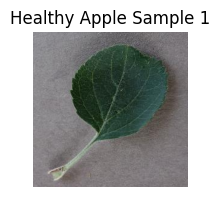

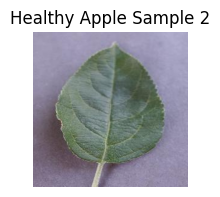

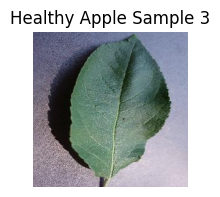

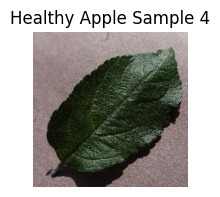

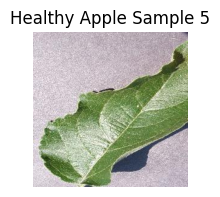

In [13]:
print("Plotting 5 samples of Apple___healthy:")
healthy_path = "Plant_leave_diseases_dataset_without_augmentation/Apple___healthy"
healthy_files_list = os.listdir(healthy_path)

num_samples = 5 # Sample
selected_healthy_files = healthy_files_list[:num_samples]

next_healthy_plant = [os.path.join(healthy_path, fname) for fname in selected_healthy_files]

for i, img_path in enumerate(next_healthy_plant):
    img = mpimg.imread(img_path)
    plt.figure(figsize=(2, 3))
    plt.imshow(img)
    plt.title(f"Healthy Apple Sample {i+1}")
    plt.axis('Off')
    plt.show()


### Train-Test-Datenaufteilung

In [26]:
import random
import shutil

# Verzeichnisse
data_dir = "Plant_leave_diseases_dataset_without_augmentation"
train_dir = "train_dataset"
val_dir = "val_dataset"
test_dir = "test_dataset"

# Erstelle Zielordner für Validierungs- Test- und Trainingsdaten
for folder in [train_dir, val_dir, test_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

# Gehe durch alle Klassen
for root, dirs, _ in os.walk(data_dir):
    for class_name in dirs:
        # Überprüfe, ob der Ordner tatsächlich Bilder enthält
        class_path = os.path.join(root, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg'))]

        if image_files:
            random.shuffle(image_files)
            total = len(image_files)
            test_split = int(0.15 * total)
            val_split = int(0.1 * (total - test_split))

            test_files = image_files[:test_split]
            val_files = image_files[test_split:test_split+val_split]
            train_files = image_files[test_split+val_split:]

            for dest_dir, files in zip([train_dir, val_dir, test_dir],
                                       [train_files, val_files, test_files]):
                dest_class_path = os.path.join(dest_dir, class_name)
                os.makedirs(dest_class_path, exist_ok=True)
                for file in files:
                    shutil.copy(os.path.join(class_path, file), os.path.join(dest_class_path, file))

print("Train-Val-Test-Datenaufteilung abgeschlossen.")

Train-Val-Test-Datenaufteilung abgeschlossen.


### Bildaugmentation für Trainingsdatensatz

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentierung für den Trainingsdatensatz
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Bildskalierung
    rotation_range=40,          # Rotation
    width_shift_range=0.2,      # Verschiebung in der Breite
    height_shift_range=0.2,     # Verschiebung in der Höhe
    shear_range=0.2,            # Scherung
    zoom_range=0.2,             # Zoom
    horizontal_flip=True,       # Horizontal spiegeln
    fill_mode='nearest'         # Füllen der leeren Stellen
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # Eingabegröße
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 42449 images belonging to 39 classes.
Found 4697 images belonging to 39 classes.
Found 8300 images belonging to 39 classes.


In [ ]:
# class_indices ausgeben
print(train_generator.class_indices)

import json
# Speichern
with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

### VGG16-Modell laden

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# VGG16 ohne die obersten Schichten (Fully-Connetcted-Schicht)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Einfrieren der Basis-Model-Schichten, um sie nicht während des Trainings zu ändern
for layer in base_model.layers:
    layer.trainable = False

# Hinzufügen von eigenen Klassifikationsschichten
model = Sequential([
    base_model,  # Vortrainiertes VGG16-Modell
    GlobalAveragePooling2D(), # m die Ausgaben eines Convolutional-Blocks zu verdichten
    Dense(512, activation='relu'),  # Dense-Schicht
    Dropout(0.5),  # Dropout zur Vermeidung von Überanpassung
    Dense(train_generator.num_classes, activation='softmax')  # Softmax für Mehrklassenklassifikation
])

# Kompilieren des Modells
model.compile(
    #optimizer=Adam(learning_rate=0.001),
    optimizer='adam',  # Adam-Optimierer
    loss='categorical_crossentropy',  # Verlustfunktion für Mehrklassenklassifikation
    metrics=['accuracy']  # Metrik zur Bewertung der Genauigkeit
)

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True), # Beendet das Training frühzeitig, wenn sich die Validierungsleistung nicht verbessert
    ModelCheckpoint("best_model.h5", save_best_only=True), # Modell speichern
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6) # Reduziert die Lernrate, wenn sich die Validierungsleistung nicht verbessert
]

# Modell trainieren
history = model.fit(
    train_generator, # Trainingsdaten mit Augmentierung
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator, # Validierungsdaten
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15, # Anzahl der Epochen
    callbacks=callbacks,
    verbose=0
)

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/15
1326/1326 [==============================] - 455s 321ms/step - loss: 1.4946 - accuracy: 0.5813 - val_loss: 0.7027 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 2/15
1326/1326 [==============================] - 366s 276ms/step - loss: 0.8008 - accuracy: 0.7522 - val_loss: 0.4765 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 3/15
1326/1326 [==============================] - 361s 272ms/step - loss: 0.6636 - accuracy: 0.7895 - val_loss: 0.4124 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 4/15
1326/1326 [==============================] - 344s 260ms/step - loss: 0.5942 - accuracy: 0.8101 - val_loss: 0.3767 - val_accuracy: 0.8808 - lr: 0.0010
Epoch 5/15
1326/1326 [==============================] - 342s 258ms/step - loss: 0.5500 - accuracy: 0.8233 - val_loss: 0.3632 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 6/15
1326/1326 [==============================] - 343s 259ms/step - loss: 0.5246 - accuracy: 0.8300 - val_loss: 0.3262 - val

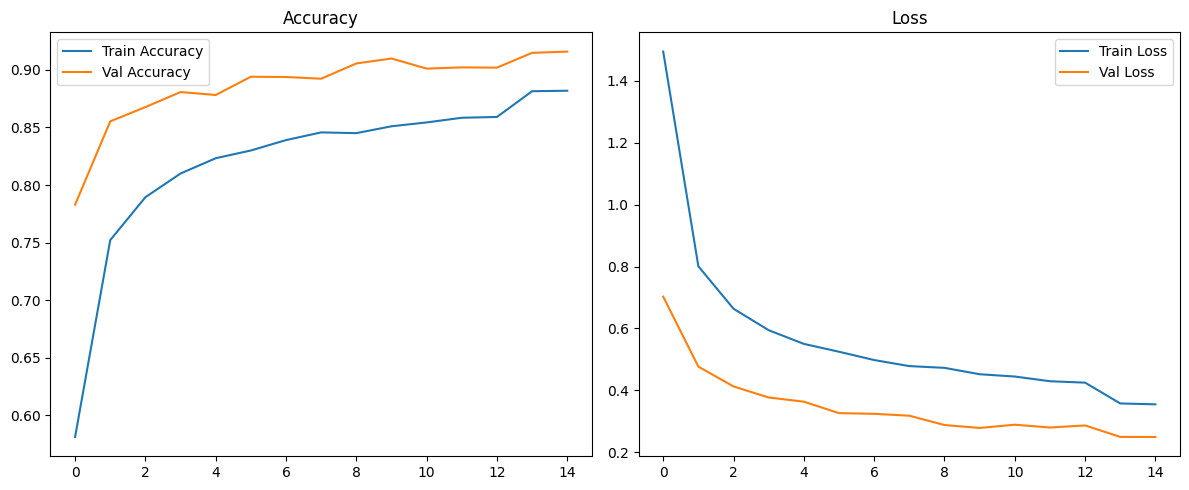

In [29]:
import matplotlib.pyplot as plt

# Visualisierung Accuracy und Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('my_model.h5')

In [ ]:
model = tf.keras.models.load_model('best_model.h5')

# Modell testen

In [33]:
# Modellbewertung auf den Testdaten
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_acc:.4f}')

259/259 [==============================] - 13s 50ms/step - loss: 0.2565 - accuracy: 0.9134
Test Accuracy: 0.9134


In [34]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_class_for_images(image_paths, model, generator):
  predictions = []
  for img_path in image_paths:
    img = load_img(img_path, target_size=(224, 224))  # Bildgröße auf 224x224 ändern
    img_array = img_to_array(img)  # Bild in Array umwandeln
    img_array = np.expand_dims(img_array, axis=0)  # Dimension für das Batch hinzufügen
    img_array = img_array / 255.0  # Skalierung

    # Vorhersage machen
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)  # Index der vorhergesagten Klasse
    # Label
    predicted_class_name = list(generator.class_indices.keys())[predicted_class[0]]
    predictions.append((img_path, predicted_class_name))  # Füge Pfad und Vorhersage hinzu
  return predictions

In [42]:
# Liste von Bildpfaden
image_paths = [
    "test_dataset/Apple___healthy/image (1005).JPG",
    "test_dataset/Apple___Apple_scab/image (103).JPG",
    "test_dataset/Cherry___Powdery_mildew/image (1004).JPG",
    "test_dataset/Corn___Common_rust/image (1002).JPG",
    "test_dataset/Corn___healthy/image (1060).jpg",
    "test_dataset/Potato___Late_blight/image (204).JPG"
]

# Ausgabe der Vorhersagen
predictions = predict_class_for_images(image_paths, model, test_generator)

# Ausgabe der Vorhersagen
for img_path, predicted_class_name in predictions:
    print(f"Bild: {img_path} -> Vorhergesagte Klasse: {predicted_class_name}")

1/1 [==============================] - 0s 15ms/step
Bild: test_dataset/Apple___healthy/image (1005).JPG -> Vorhergesagte Klasse: Apple___healthy
Bild: test_dataset/Apple___Apple_scab/image (103).JPG -> Vorhergesagte Klasse: Apple___Apple_scab
Bild: test_dataset/Cherry___Powdery_mildew/image (1004).JPG -> Vorhergesagte Klasse: Cherry___Powdery_mildew
Bild: test_dataset/Corn___Common_rust/image (1002).JPG -> Vorhergesagte Klasse: Corn___Common_rust
Bild: test_dataset/Corn___healthy/image (1060).jpg -> Vorhergesagte Klasse: Corn___healthy
Bild: test_dataset/Potato___Late_blight/image (204).JPG -> Vorhergesagte Klasse: Potato___Late_blight


260/260 [==============================] - 12s 48ms/step


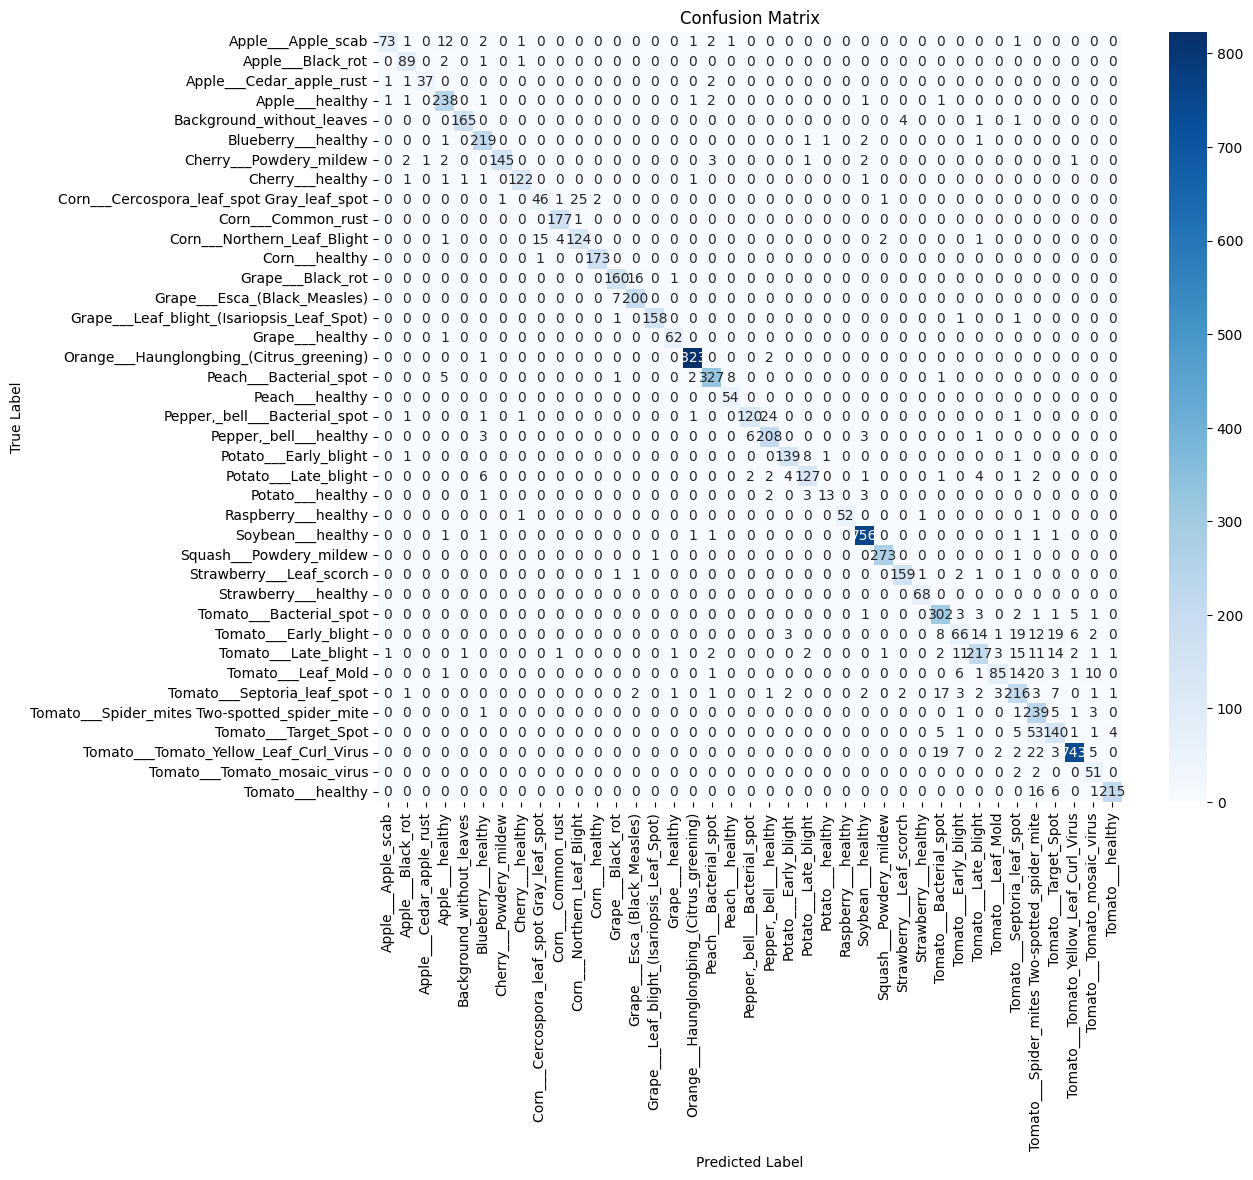

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Confusion Matrix
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm, class_labels)

In [44]:
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.96      0.78      0.86        94
                            Apple___Black_rot       0.91      0.96      0.93        93
                     Apple___Cedar_apple_rust       0.97      0.90      0.94        41
                              Apple___healthy       0.90      0.97      0.93       246
                    Background_without_leaves       0.99      0.96      0.98       171
                          Blueberry___healthy       0.92      0.97      0.95       225
                      Cherry___Powdery_mildew       0.99      0.92      0.96       157
                             Cherry___healthy       0.97      0.95      0.96       128
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.74      0.61      0.67        76
                           Corn___Common_rust       0.97      0.99      0.98       178
                  C